# Process Discovery
*by: Sebastiaan J. van Zelst*

Since we have studied basic conceptual knowledge of process mining and event data munging and crunching, we focus on process discovery.
Here, the goal is to discover, i.e., primarily completely automated and algorithmically, a process model that accurately describes the process, i.e., as observed in the event data.
For example, given the running example event data, we aim to discover the process model that we have used to explain the running example's process behavior.
For example, when using the [sample event log](data/running_example.csv) we have seen before, we aim to discover:

![Running example BPMN-based process model describing the behavior of the simple process that we use in this tutorial](img/bpmn_running_example.png)

This section briefly explains what modeling formalisms exist in PM4Py while applying different process discovery algorithms.
Secondly, we give an overview of the implemented process discovery algorithms, their output type(s), and how we can invoke them.
Finally, we discuss the challenges of applying process discovery in practice.
Note that, we will not explain the internal workings of the algorithms presented here.
For more information regarding the algorithmic details, consider the [Coursera MOOC](https://www.coursera.org/learn/process-mining), the papers/articles/web pages we refer to in the notebook, or, contact us for in-depth algorithmic training :-).

## Obtaining a Process Model

There are three different process modeling notations that are currently supported in PM4Py.
These notations are: [BPMN](https://www.bpmn.org/), i.e., models such as the ones shown earlier in this tutorial, *Process Trees* and *Petri nets*.
A Petri net is a more mathematical modeling representation compared to BPMN.
Often, the behavior of a Petri net is more difficult to comprehend compared to BPMN models.
However, due to their mathematical nature, Petri nets are typically less ambiguous (i.e., confusion about their described behavior is not possible).
Process Trees represent a strict subset of Petri nets and describe process behavior in a hierarchical manner.
In this tutorial, we will focus primarily on BPMN models and process trees.
For more information about Petri nets and their application to (business) process modeling (from a ‘workflow’ perspective), we refer to [this article](https://www.researchgate.net/profile/Wil_Aalst/publication/220337578_The_Application_of_Petri_Nets_to_Workflow_Management/links/0deec517a563a45197000000/The-Application-of-Petri-Nets-to-Workflow-Management.pdf?_sg%5B0%5D=2TrqDbNsoZEr67XgOwI_9qxtlO_S1HJFHn8edW7aE0fMWzmsY0D1GhrsbRXdtZhTLvQ1KcSm9pkLzooDMl-eRg.DhnNamQg4EvK8MAwucwkB1VDke7eNq0E4jxMAa2IMXXZtvr9k1PPiwZpQEt1Z2iqkdkN-SOlWyjFloP-BivLow&_sg%5B1%5D=XeHToX2_7feAtM6yO395-HEYttSzdWJeiLaGlD_7Dn3hRXYnVXya0-dHm5RWmjX22gF3ton7d7FSzF6FjL_NYZCQzRvJuPg4zPWnk_HCe0xj.DhnNamQg4EvK8MAwucwkB1VDke7eNq0E4jxMAa2IMXXZtvr9k1PPiwZpQEt1Z2iqkdkN-SOlWyjFloP-BivLow&_iepl=).

Interestingly, none of the algorithms implemented in PM4Py directly discovers a BPMN model.
However, any process tree can easily be translated to a BPMN model.
Since we have already discussed the basic operators of BPMN models, we will start with the discovery of a process tree, which we convert to a BPMN model.
Later, we will study the ‘underlying’ process tree.
The algorithm that we are going to use is the ‘Inductive Miner’;
More details about the (inner workings of the) algorithm can be found in [this presentation](http://www.processmining.org/_media/presentations/2013/petri_nets.pptx) and in [this article](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.396.197&rep=rep1&type=pdf).
Consider the following code snippet showing how to obtain a BPMN model from an event log.

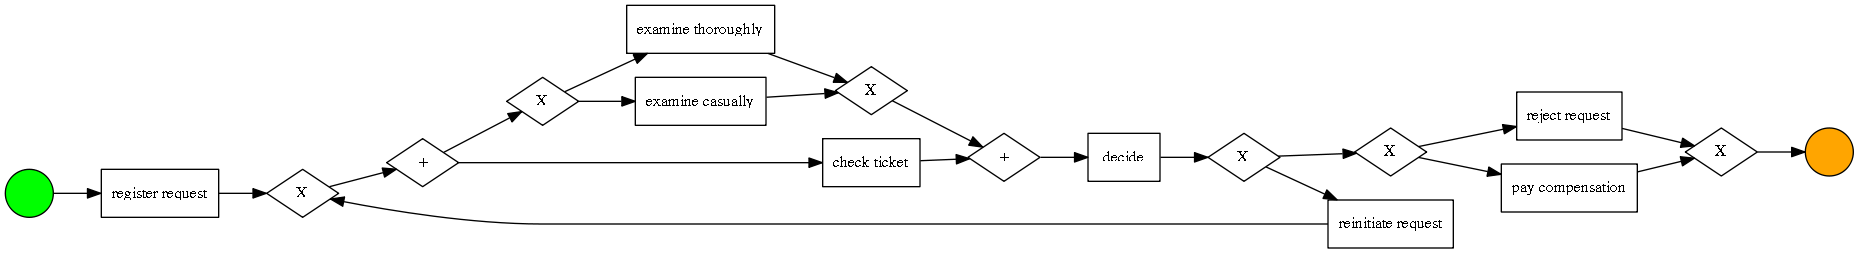

In [45]:
import pandas as pd
import pm4py
df = pm4py.format_dataframe(pd.read_csv('data/running_example.csv', sep=';'), case_id='case_id',activity_key='activity',
                             timestamp_key='timestamp')
bpmn_model = pm4py.discover_bpmn_inductive(df)
pm4py.view_bpmn(bpmn_model)

Observe that the process model that we discovered, describes the same behavior as the model that we have shown above.

As indicated, the algorithm used in this example actually discovers a *Process Tree*.
Such a process tree is, mathematically speaking, a *rooted tree*, annotated with ‘control-flow’ information.
We’ll first use the following code snippet to discover a process tree based on the running example, and, afterwards shortly analyze the model.

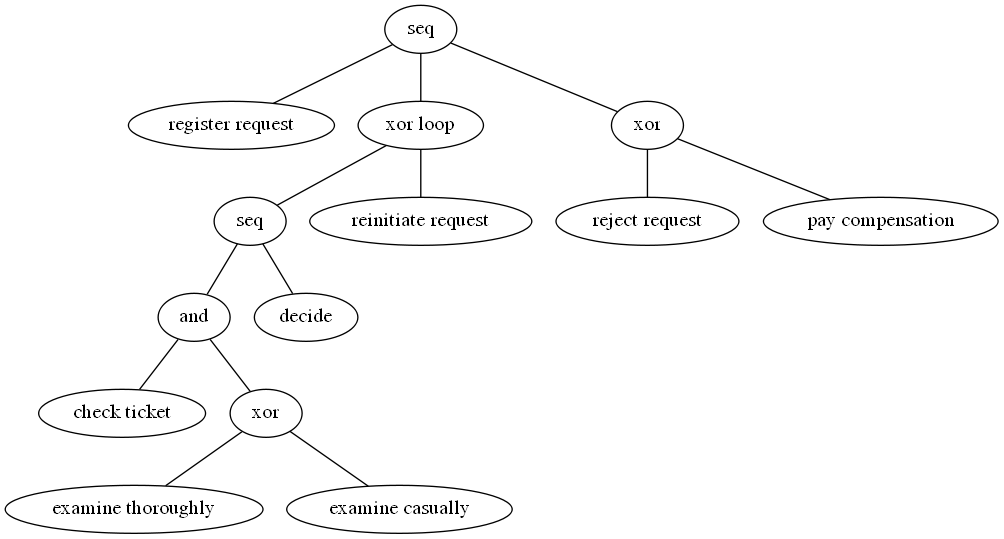

In [46]:
process_tree = pm4py.discover_process_tree_inductive(df)
pm4py.view_process_tree(process_tree)

We'll analyze the process tree model from top to bottom.
The first circle, i.e., the ‘root’ of the process tree, describes a ‘->’ symbol.
This means that, when srolling further down, the process described by the model executes the ‘children’ of the root from left to right.
Hence, first “register request” is executed, followed by the circle node with the ‘\*’ symbol, finally to be followed by the node with the ‘X’ symbol.
The node with the ‘\*’ represents ‘repeated behavior’, i.e., the possibility to repeat the behavior.
When scrolling further down, the left-most ‘subtree’ of the ‘\*’-operator is always executed, the right-most child (in this case, “reinitiate request”) triggers a repeated execution of the left-most child.
Observe that this is in line with the process models we have seen before, i.e., the “reinitiate request” activity allows us to repeat the behavior regarding examinations and checking the ticket.
When we go further down below in the subtree of the ‘\*’-operator, we again observe a ‘->’ node.
Hence, its left-most child is executed first, followed by its right-most child (“decide”).
The left-most child of the ‘->’ node has a ‘+’ symbol.
This represents concurrent behavior; hence, its children can be executed simultaneously or in any order.
Its left-most child is the “check ticket” activity.
Its right-most child is a node with an ‘X’ symbol (just like the right-most child of the tree's root).
This represents an exclusive choice, i.e., one of the children is executed (either “examine casually” or “examine thoroughly”).
Observe that the process tree describes the exact same behavior as the BPMN models shown before.

There are different ways to obtain a petri net:
- Let the algorithm directly return a Petri net.
- Convert the obtained process tree to a Petri net (recall that process trees are a strict sub-class of Petri nets).
For example:

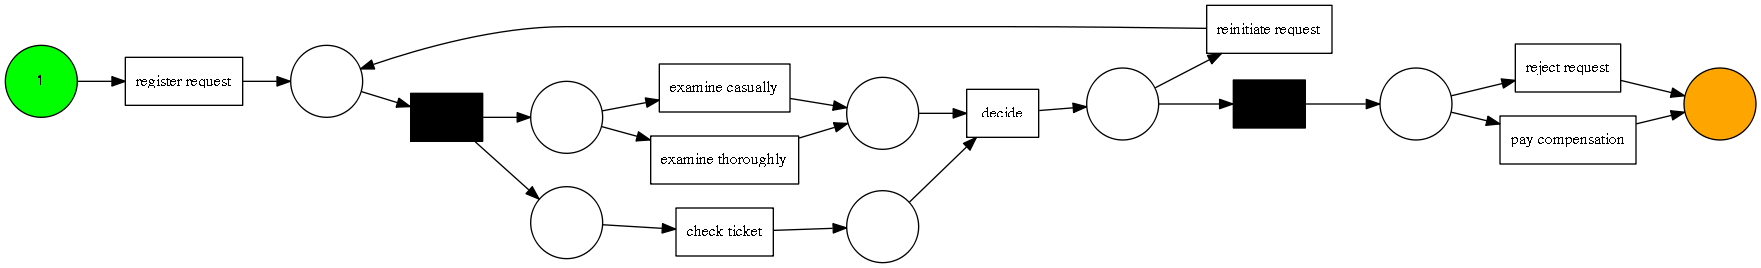

In [47]:
net1, im1, fm1 = pm4py.convert_to_petri_net(process_tree)
pm4py.view_petri_net(net1,im1,fm1)

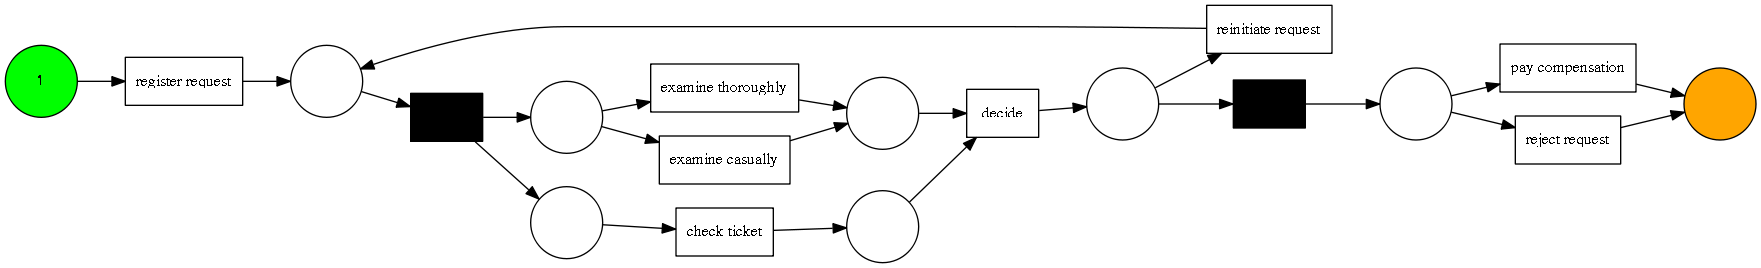

In [48]:
net2, im2, fm2 = pm4py.discover_petri_net_inductive(df)
pm4py.view_petri_net(net2, im2, fm2)

Observe that both functions return three arguments, i.e., the Petri net, an initial and a final marking.
Unsurprisingly, the two models are the same (i.e., the ```pm4py.discover_petri_net_inductive(df)``` function applies the conversion internally).
However, there are alternative algorithms implemented in pm4py, that allow you obtain a Petri net based on an event log.
These algorithms are:
* [The alpha miner](https://en.wikipedia.org/wiki/Alpha_algorithm); One of the first process discovery algorithms
* [The alpha+ miner](https://pure.tue.nl/ws/files/1864325/576199.pdf); Extension of the alpha miner that handles length-one-loops and short loops.

Invocation of the aformentioned algorithms is straightforward:

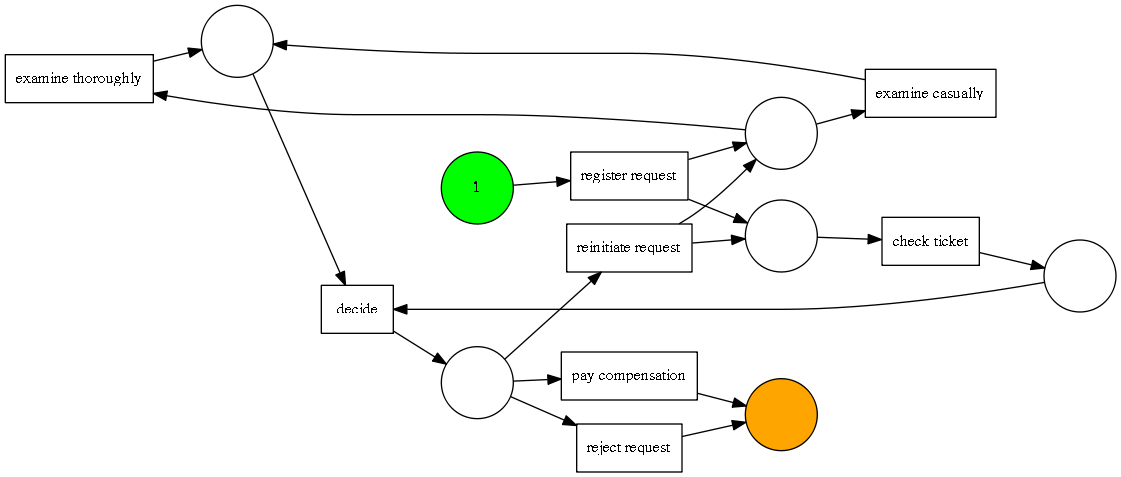

In [49]:
net3, im3, fm3 = pm4py.discover_petri_net_alpha(df)
pm4py.view_petri_net(net3, im3, fm3)

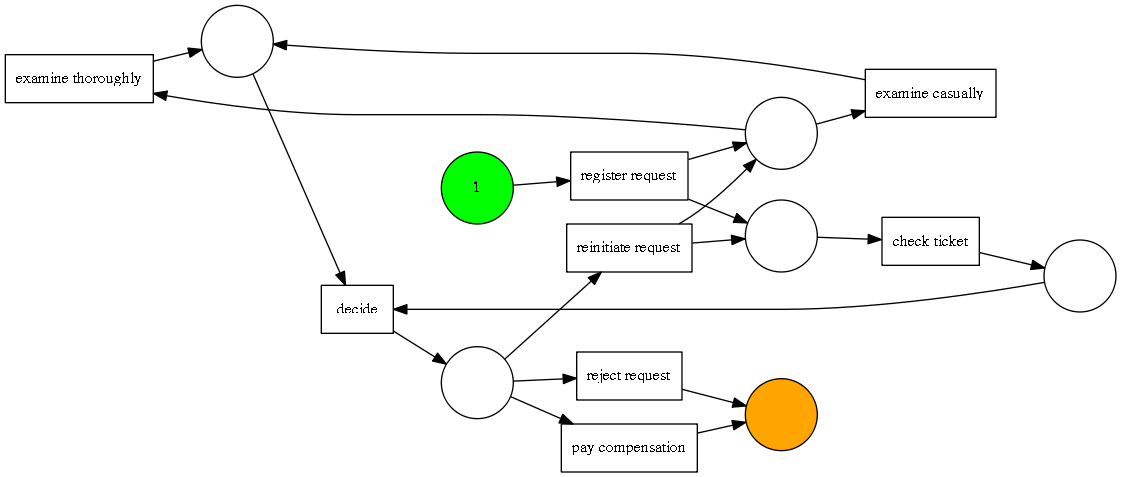

In [50]:
net4, im4, fm4 = pm4py.discover_petri_net_alpha_plus(df)
pm4py.view_petri_net(net4, im4, fm4)

Note that, by definition, the alpha miner variants cannot discover invisible transitions (black boxes).
Additionally, these algorithms have no form of formal quality guarantees w.r.t. the resulting process models.
As such, **we strongly discourage the use of the alpha miners in practice, apart from educational purposes.**

## Obtaining a Process Map

Many [commercial process mining solutions](https://www.gartner.com/reviews/market/process-mining) do not provide extended support for discovering process models.
Often, as a main visualization of processes, *process maps* are used.
A process map contains activities and connections (by means of arcs) between them.
A connection between two activities usually means that there some form of precedence relation.
In its simplest form, it means that the ‘source’ activity directly precedes the ‘target’ activity.
Let’s quickly take a look at a concrete example!
Consider the following code snippet, in which we learn a ‘Directly Follows Graph’ (DFG)-based process map.

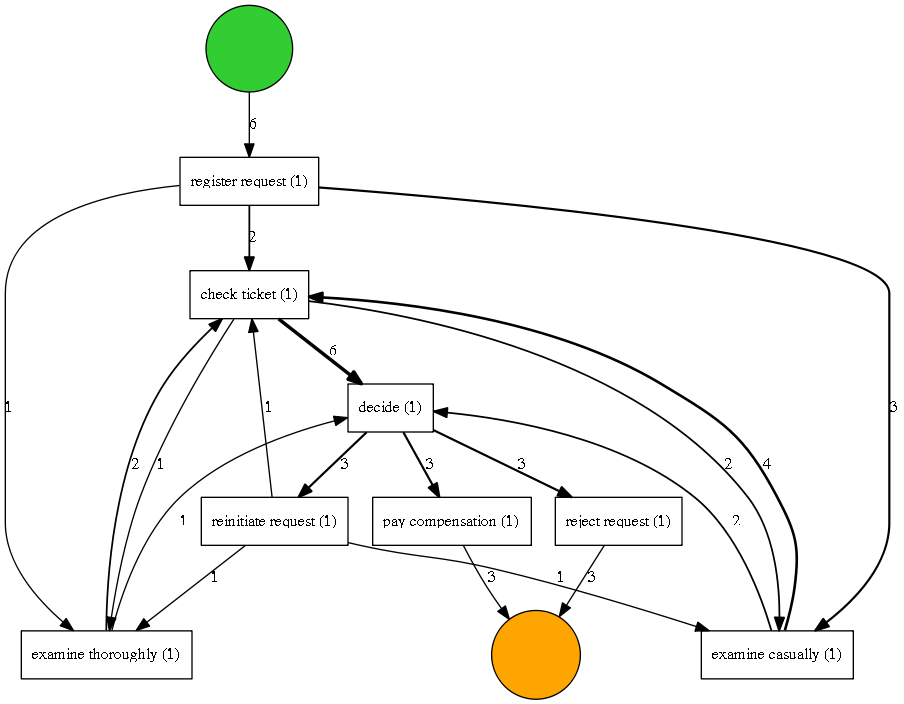

In [51]:
dfg, start_activities, end_activities = pm4py.discover_dfg(df)
pm4py.view_dfg(dfg, start_activities, end_activities)

The pm4py.discover_dfg(log) function returns a triple.
The first result, i.e., called dfg in this example, is a dictionary mapping pairs of activities that follow each other directly, to the number of corresponding observations.
The second and third arguments are the start and end activities observed in the event log (again counters).
In the visualization, the green circle represents the start of any observed process instance.
The orange circle represents the end of an observed process instance.
In 6 cases, the register request is the first activity observed (represented by the arc labeled with value 6).
In the event log, the check ticket activity is executed directly after the register request activity.
The examine thoroughly activity is following registration once, examine casually follows 3 times.
Note that, indeed, in total, the register activity is followed by 6 different events, i.e., there are 6 traces in the running example event log.
However, note that there are typically much more relations observable compared to the number of cases in an event log.
Even using this simple event data, the DFG-based process map of the process is much more complex than the process models learned earlier.
Furthermore, it is much more difficult to infer the actual execution of the process based on the process map.
Hence, when using process maps, one should be very carefully when trying to comprehend the actual process.

In PM4Py, we also implemented the [Heuristics Miner](https://ieeexplore.ieee.org/iel5/5937059/5949295/05949453.pdf), a more advanced process map discovery algorithm, compared to its DFG-based alternative.
We won’t go into the algorithmic details here, however, in a HM-based process map, the arcs between activities represent observed concurrency.
For example, the algorithm is able to detect that the ticket check and examination are concurrent.
Hence, these activities will not be connected in the process map.
As such, a HM-based process map is typically simpler compared to a DFG-based process map.

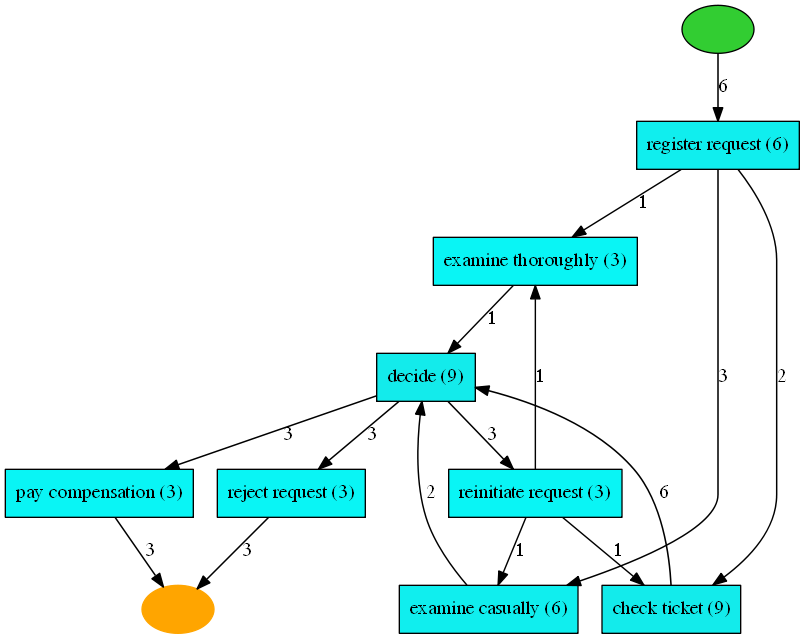

In [52]:
map = pm4py.discover_heuristics_net(df)
pm4py.view_heuristics_net(map)

## Advanced Discovery: Handling Noise

In the [previous tutorial](2_event_data_filtering.ipynb), we have already seen some generic ways of data filtering.
However, most of the functionalities presented there are useful for preprocessing the event data.
After preprocessing, it often happens that event data is still containing various 'problematic cases' that were hard to filter out.
We won't go into too much detail here, however, various causes of outliers and noise in cleaned event data exist.
Some algorithms have built-in filtering mechanisms, allowing you to filter the cleaned event data internally.

Consider the following example, in which we use a 'broken' variant of the running example data (some events are missing), with and without filtering.

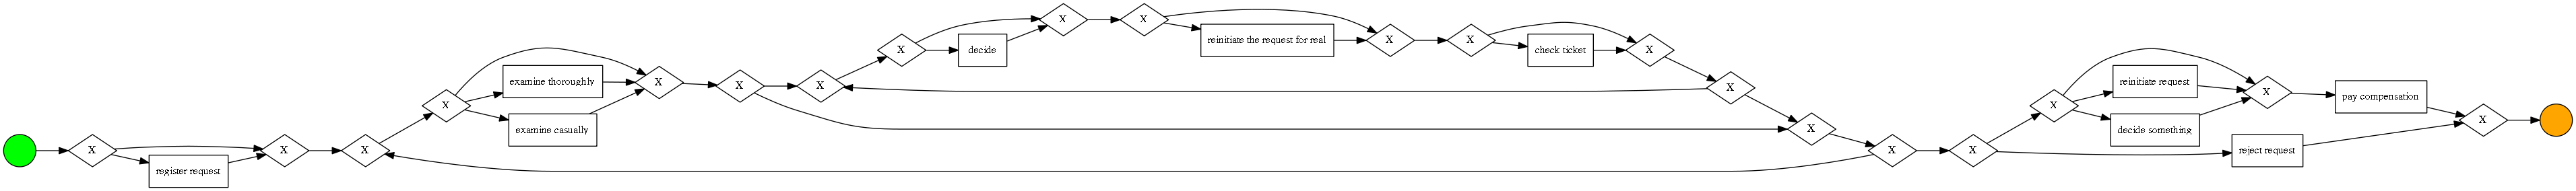

In [53]:
df_broken = pd.read_csv('data/running_example_broken.csv', sep=';')
df_broken = pm4py.format_dataframe(df_broken)bpmn_unfiltered = pm4py.discover_bpmn_inductive(df_broken)
pm4py.view_bpmn(bpmn_unfiltered)

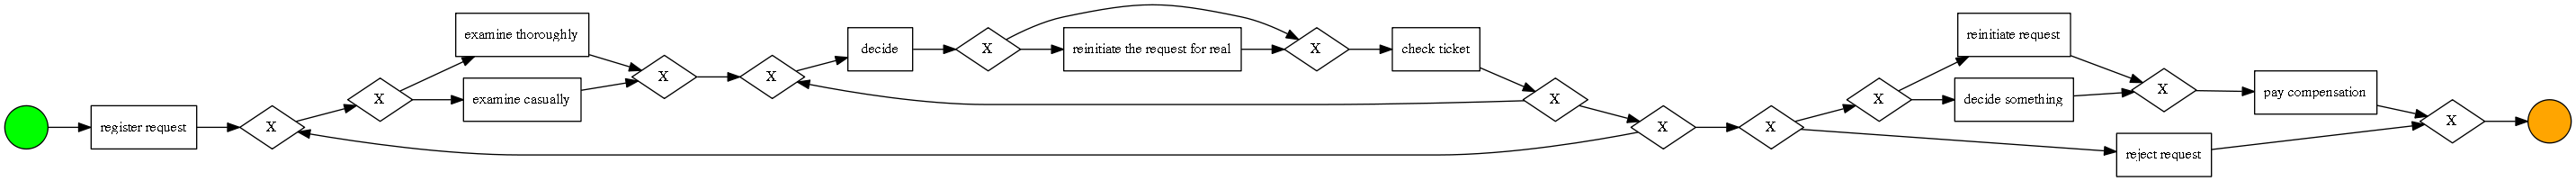

In [54]:
bpmn_filtered = pm4py.discover_bpmn_inductive(df_broken, 0.8)
pm4py.view_bpmn(bpmn_filtered)

Observe that the first model, i.e., without any form of filtering, allows us to skip a large part of the model.
Furthermore, the model describes various 'options to go back'.
Hence, we can arbitrarily skip a lot of activities, yet, go back to previous states in the process at the same time.
This implies that the model, in fact, describes that virtually anything can happen.

The other model, on the other hand, applies rigorous filtering.
As a result, the process model does no longer describe all possible behavior in the input event log (a guarantee by the Inductive Miner without filtering).
However, it describes much less variation.
Arguably, this is a better model for the given event data since it is much more *precise*.

## Final Thoughts
The examples presented here show some great process discovery in action.
However, this article would not be complete without a few critical notes from an academic that has spent a large part of his professional career in developing and applying process mining algorithms.
First and foremost, make sure to play around with some real event data, which you can download [here](http://processmining.org/event-data.html).
You will most likely notice that the models you discover (even with various filtering threshold values) are largely useless.
They either are i) too complex or ii) too imprecise.
There are various reasons for this, some of which, we'll briefly touch upon here:
- *Data Granularity Mismatch*; The process models that we use to model (business) processes tend to be of a certain level of abstraction.
For example, in the running example, we describe the registration of a request simply as 'register request'.
However, it is very likely that the system modeling said registration, registers the effective registration request at a lower level.
Various system calls and data-base overwrites may be logged in the event data.
Often, these low level events do not follow a pre-defined sequential pattern, hence, large variability may easily exit.
Larger variability implies a larger data complexity, i.e., if 10 activities are able to occur in parallel, this implies that there are 10!=10\*9\*8\*...\*1=3.628.800 ways to schedule these activities.
However, natural bias and skew in the process execution exists, which often renders us to observe an incomplete subset.
Hence, to obtain a more reasonable process model, the recorded event data may need to be *abstracted* first.
For an elaborate overview, see [this article](http://sebastiaanvanzelst.com/wp-content/uploads/2020/04/Granular_Computing_in_Process_Mining.pdf).
- *No Contextual Activity Differentiation*;
The state-of-the-art discovery algorithms consider every activity of the same type, to be of the same type.
That sounds vague, however, an example easily clarifies this problem.
Consider modeling a process model of your daily routine.
It is likely that you sometimes shower in the morning, and, sometimes in the evening.
When modeling this as a process model, i.e., when you as a human modeler model this, it is likely that you actually create two shower activities in the model.
One of these activities represents taking a shower in the morning, whereas the other represents taking a shower in the evening.
Hence, when learning a process model of your daily routine, the discovery algorithm will place both your breakfast, and your diner close to the showering activity.
In fact, it will likely allow you to skip breakfast and diner, and, allow you to 'go back' to the dinner.
That is, the exact same problem occurs as the problem that we already observed when learning process models based on noisy data.
There are some solutions for this problem, i.e., referred to as 'label splitting' (see [this article](https://pure.tue.nl/ws/files/58626874/BPM2016Lu.pdf)).
In a nutshell, such an algorithm tries to detect if certain activities (such as 'showering') should be split up in say, an activity 'shower1' and 'shower2'.
After such a split, the algorithm will learn activity instances for both 'shower1' and 'shower2', which we can both replace by the 'shower' activity in a post-processing step.
- *Ignorance of Activity Duration*
The majority of the existing process discovery algorithms assume activities to be of an atomic fashion (i.e., they have a single timestamp and no duration).
In reality, however, most activities take some time (even automated system activities tend to take a few milliseconds).
Whereas the XES standard provides means to differentiate between start and end activities, hardly any discovery algorithm uses this information (e.g., the Inductive Miner - Life Cycle Algorithm (IMLC) does use this information).
As such, process models tend to become complex, since activity start and end are modeled in a separate manner.
Note that, even in case activities are recorded as atomic events, after applying event abstraction (i.e., see the previous point on *Data Granularity*), activity start and end timestamps are present by definition.
- *Ignorance of Domain Knowledge*
Most process discovery algorithms only look at the sequential ordering of (atomic) events, i.e., the do not exploit any indicative auxillary data.
Furthermore, they provide limited to no user interaction.
It might be the case that a certain execution of a process is happening frequently, yet, should not be executed as it is recorded, i.e., one does not aim to model the specific execution within the model.
Since the majority of the filtering algorithms that exist use trace-frequency as a primary driver (implicitly or explicitly) these type of problems will not be identified.
For example, in a real life, publicly available log concerning the administration of road-traffic fines, one of the most ocurring process executions is represented by offenders that do not pay the fine.
Clearly, one wants to exclude the possibility of not paying from any discovered representative model (although observing the fact that this happens is extremely valuable for the business).
Novel developments in the field of process mining put more emphasis on such domain knowledge integration.
For example, consider the recently rleased process discovery tool [CORTADO](http://cortado.fit.fraunhofer.de).

These problems described here, are just a few problems (of the many) that hamper the direct application of process mining (for example, we did not even cover the n:m-relation problem of objects and events).
This does not mean that process discovery is useless.
Rather, it is important to take into account that a discovered process model is just the starting point of an event data analysis, i.e., not the end result.
Truth be told, when analyzing real event data, visual analytic tools (e.g., the [Variant Explorer](https://fmannhardt.de/blog/static/3770b2fe8bbe79afd99c0368f22ab931/d56b5/explore-event-log.png) and the [Dotted Chart](https://a.fsdn.com/con/app/proj/prom/screenshots/LogProjection.png/max/max/1)) can reveal various useful patterns that provide insights into a process and allow further event data preprocessing.


